**Install requirements**

In [2]:
pip install pyramid-arima

     |████████████████████████████████| 604kB 2.8MB/s 


In [3]:
!pip uninstall scikit-learn
!pip install scikit-learn


Uninstalling scikit-learn-0.22.1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/scikit_learn-0.22.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/sklearn/*
Proceed (y/n)? y
  Successfully uninstalled scikit-learn-0.22.1
     |████████████████████████████████| 7.1MB 2.8MB/s 


In [4]:
!pip install chart_studio

***Import Libraries***

In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import chart_studio.plotly as plot_mpl
import plotly.graph_objs as go
import xgboost as xgb
import keras.backend as K
import tensorflow as tf

from math import sqrt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from pyramid.arima import auto_arima

from socket import socket
from statsmodels.tsa.seasonal import seasonal_decompose

from keras.models import Sequential
from keras.layers import Conv1D, LSTM, TimeDistributed, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.

/usr/local/lib/python3.6/dist-packages/pyramid/__init__.py:68: UserWarning:


    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https:/

In [0]:
#Set parameters to see all data
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [0]:
from google.colab import files

In [8]:
#Upload train data set file from local to colabs area
uploaded = files.upload()

Saving sales_dataset.csv to sales_dataset.csv


In [89]:
# Load Train dataset
train = pd.read_csv("sales_dataset.csv")
train.head(5).append(train.tail(5))

,Month,Sales
0,1984-01,2815
1,1984-02,2672
2,1984-03,2755
3,1984-04,2721
4,1984-05,2946
100,1992-05,4618
101,1992-06,5312
102,1992-07,4298
103,1992-08,1413
104,1992-09,5877


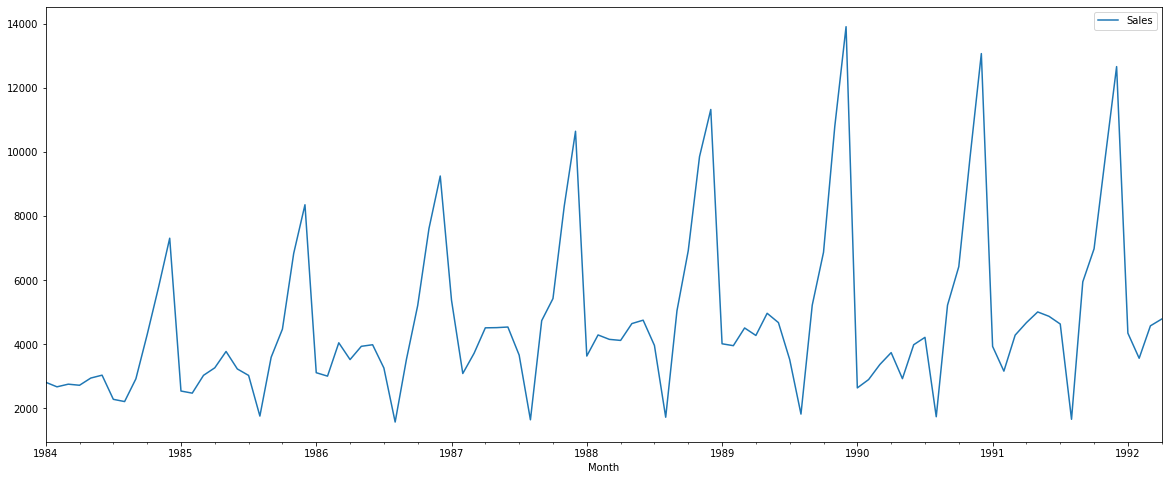

In [386]:
#Plot data
train[:100].plot(figsize=(20,8))

In [91]:
train.shape

(105, 2)

In [92]:
train.dtypes

Month    object
Sales     int64
dtype: object

# **Preprocess**

In [0]:
train = train.set_index(['Month'])

In [0]:
train.index = pd.to_datetime(train.index)

In [95]:
train.dtypes

Sales    int64
dtype: object

In [0]:
#Stationary Control
#if P-Value is smaller than 0.005, we can say that there is stationary, else there is no stationary
#if our data has no stationary, I will plan to use differences

class Stationary:
    def __init__(self, significance=.005):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None

    def ADF_Stationarity_Test(self, timeseries, printResults=True):

        # Dickey-Fuller test:
        print(timeseries)
        try:
            adfTest = adfuller(timeseries, autolag='AIC')

            self.pValue = adfTest[1]

            if (self.pValue < self.SignificanceLevel):
                self.isStationary = True
            else:
                self.isStationary = False
            #self.isStationary=True
            if printResults:
                dfResults = pd.Series(adfTest[0:4],
                                      index=['ADF Test Statistic', 'P-Value', '# Lags Used', '# Observations Used'])

                # Add Critical Values
                for key, value in adfTest[4].items():
                    dfResults['Critical Value (%s)' % key] = value

                print('Augmented Dickey-Fuller Test Results:')
                print(dfResults)
        except Exception as e:
          print(e)
          self.isStationary = False

In [0]:
sTest = Stationary()

In [98]:
sTest.ADF_Stationarity_Test(train['Sales'])
print(sTest.isStationary)

Month
1984-01-01     2815
1984-02-01     2672
1984-03-01     2755
1984-04-01     2721
1984-05-01     2946
1984-06-01     3036
1984-07-01     2282
1984-08-01     2212
1984-09-01     2922
1984-10-01     4301
1984-11-01     5764
1984-12-01     7312
1985-01-01     2541
1985-02-01     2475
1985-03-01     3031
1985-04-01     3266
1985-05-01     3776
1985-06-01     3230
1985-07-01     3028
1985-08-01     1759
1985-09-01     3595
1985-10-01     4474
1985-11-01     6838
1985-12-01     8357
1986-01-01     3113
1986-02-01     3006
1986-03-01     4047
1986-04-01     3523
1986-05-01     3937
1986-06-01     3986
1986-07-01     3260
1986-08-01     1573
1986-09-01     3528
1986-10-01     5211
1986-11-01     7614
1986-12-01     9254
1987-01-01     5375
1987-02-01     3088
1987-03-01     3718
1987-04-01     4514
1987-05-01     4520
1987-06-01     4539
1987-07-01     3663
1987-08-01     1643
1987-09-01     4739
1987-10-01     5428
1987-11-01     8314
1987-12-01    10651
1988-01-01     3633
1988-02-01    

## **P-Values is higher than 0.005, so there no stationary.**

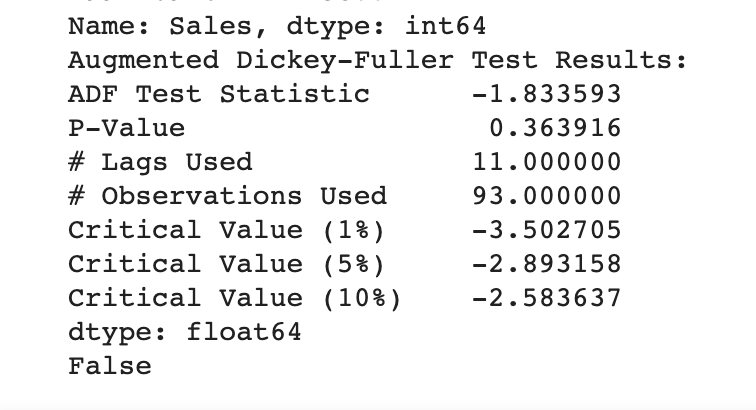

In [0]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        # print(interval, dataset[i], dataset[i - interval])
        diff.append(value)
    return pd.Series(diff)

In [0]:
diff_values = difference(train['Sales'], 1)

In [0]:
 # split train test datasets
 xtrain, xtest = diff_values[0:-9], diff_values[-9:]

In [102]:
xtest

95    -8322
96     -784
97     1013
98      211
99     -170
100     694
101   -1014
102   -2885
103    4464
dtype: int64

In [0]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    dfx = pd.DataFrame(data)
    df = dfx.assign(**{
        '{} (t-{})'.format(col, t): dfx[col].shift(t)
        for t in range(lag+1)
        for col in dfx
    })

    df=df.drop([df.columns[0]], axis=1)
    df=df[df.columns[::-1]]
    return df[lag:]

In [0]:
# scale train and test data to [-1, 1] with MinMaxScaler
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler()  
    
    # StandardScaler()
    scaler = scaler.fit(train)

    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    tr_scaled = scaler.transform(train)

    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    ts_scaled = scaler.transform(test)
    
    return scaler, tr_scaled, ts_scaled

In [0]:
# reorganize dataset acording to window size
values_unscaled = np.concatenate((xtrain, xtest))
supervised_raw = timeseries_to_supervised(values_unscaled, 12)

In [390]:
supervised_raw

array([[ -143.,    83.,   -34., ...,  1548., -4771.,   -66.],
       [   83.,   -34.,   225., ..., -4771.,   -66.,   556.],
       [  -34.,   225.,    90., ...,   -66.,   556.,   235.],
       ...,
       [ -241., -2974.,  4292., ...,  -170.,   694., -1014.],
       [-2974.,  4292.,  1030., ...,   694., -1014., -2885.],
       [ 4292.,  1030.,  2870., ..., -1014., -2885.,  4464.]],
      dtype=float32)

In [0]:
supervised_raw = supervised_raw.values.astype("float32")

In [108]:
supervised_raw

array([[ -143.,    83.,   -34., ...,  1548., -4771.,   -66.],
       [   83.,   -34.,   225., ..., -4771.,   -66.,   556.],
       [  -34.,   225.,    90., ...,   -66.,   556.,   235.],
       ...,
       [ -241., -2974.,  4292., ...,  -170.,   694., -1014.],
       [-2974.,  4292.,  1030., ...,   694., -1014., -2885.],
       [ 4292.,  1030.,  2870., ..., -1014., -2885.,  4464.]],
      dtype=float32)

In [0]:
scaler, train_scaled, test_scaled = scale(xtrain.values.reshape(len(xtrain), 1), xtest.values.reshape(len(xtest), 1))

In [0]:
values_scaled = np.concatenate((train_scaled, test_scaled))

In [0]:
supervised = timeseries_to_supervised(values_scaled, 12)

supervised_values = supervised.values.astype('float32')

##split supervised data into train and test-sets
supervised_train, supervised_test = supervised_raw[0:-9], supervised_raw[-9:]
train_scaled, test_scaled = supervised_values[0:-9], supervised_values[-9:]

In [112]:
train_scaled

array([[0.71513903, 0.7296551 , 0.72214013, ..., 0.82375234, 0.4178817 ,
        0.7200848 ],
       [0.7296551 , 0.72214013, 0.7387758 , ..., 0.4178817 , 0.7200848 ,
        0.760036  ],
       [0.72214013, 0.7387758 , 0.7301047 , ..., 0.7200848 , 0.760036  ,
        0.7394181 ],
       ...,
       [0.8015929 , 0.9438628 , 0.93204445, ..., 0.5333034 , 1.        ,
        0.7904811 ],
       [0.9438628 , 0.93204445, 0.13713148, ..., 1.        , 0.7904811 ,
        0.90866464],
       [0.93204445, 0.13713148, 0.6747383 , ..., 0.7904811 , 0.90866464,
        0.9053889 ]], dtype=float32)

In [0]:
train_X, train_y = train_scaled[:, :-1], train_scaled[:, -1]
test_X, test_y = test_scaled[:, :-1], test_scaled[:, -1]

In [114]:
train_y.reshape(train_y.shape[0], 1)

array([[0.7200848 ],
       [0.760036  ],
       [0.7394181 ],
       [0.7570814 ],
       [0.6892543 ],
       [0.7113495 ],
       [0.6428158 ],
       [0.84225065],
       [0.78078234],
       [0.8761642 ],
       [0.82188964],
       [0.3875008 ],
       [0.71745133],
       [0.79118764],
       [0.69066733],
       [0.7509153 ],
       [0.72747123],
       [0.67769283],
       [0.61596763],
       [0.84989405],
       [0.8324234 ],
       [0.87866914],
       [0.8296615 ],
       [0.47517502],
       [0.57742953],
       [0.764789  ],
       [0.77545124],
       [0.72470933],
       [0.72554433],
       [0.66805834],
       [0.594579  ],
       [0.9231807 ],
       [0.7685786 ],
       [0.90969235],
       [0.87442994],
       [0.27355644],
       [0.7666517 ],
       [0.7154602 ],
       [0.7222044 ],
       [0.75810903],
       [0.7311324 ],
       [0.6737106 ],
       [0.5803199 ],
       [0.9378894 ],
       [0.8446914 ],
       [0.91290385],
       [0.81893504],
       [0.254

In [0]:
# prepare train dataset for lstm
train_X_lstm = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X_lstm = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [0]:
# prepare test dataset for lstm
train_Y_lstm = train_y.reshape((train_y.shape[0], 1, 1))
test_Y_lstm = test_y.reshape((test_y.shape[0], 1, 1))

In [117]:
test_scaled[:, -1]

array([0.18980025, 0.6739675 , 0.7893892 , 0.73787653, 0.71340483,
       0.76889974, 0.6591945 , 0.5390198 , 1.0110476 ], dtype=float32)

In [118]:
train_y

array([0.7200848 , 0.760036  , 0.7394181 , 0.7570814 , 0.6892543 ,
       0.7113495 , 0.6428158 , 0.84225065, 0.78078234, 0.8761642 ,
       0.82188964, 0.3875008 , 0.71745133, 0.79118764, 0.69066733,
       0.7509153 , 0.72747123, 0.67769283, 0.61596763, 0.84989405,
       0.8324234 , 0.87866914, 0.8296615 , 0.47517502, 0.57742953,
       0.764789  , 0.77545124, 0.72470933, 0.72554433, 0.66805834,
       0.594579  , 0.9231807 , 0.7685786 , 0.90969235, 0.87442994,
       0.27355644, 0.7666517 , 0.7154602 , 0.7222044 , 0.75810903,
       0.7311324 , 0.6737106 , 0.5803199 , 0.9378894 , 0.8446914 ,
       0.91290385, 0.81893504, 0.25448006, 0.7205344 , 0.7598433 ,
       0.7092941 , 0.7687713 , 0.705633  , 0.65020233, 0.6150042 ,
       0.9427709 , 0.8303038 , 0.9768129 , 0.9242726 , 0.        ,
       0.74102384, 0.7545764 , 0.74808913, 0.67210484, 0.79234374,
       0.73916113, 0.56509733, 0.94803774, 0.8015929 , 0.9438628 ,
       0.93204445, 0.13713148, 0.6747383 , 0.79651874, 0.74937

In [119]:
train_y.shape

(83,)

# **XGBRegressor**

In [41]:
# XGBRegressor Training
now = datetime.now()
print("Process started at : ",now)

parameters = { 'gamma' : [0, 0.1, 0.3, 1], 'learning_rate' : [0.001, 0.01, 0.1], 
              'max_depth' : [2, 4, 6, 7, 12], 
              'n_estimators' : [10, 45, 90, 100, 150, 250],
              'nthread' : [-1], 'reg_alpha' : [1], 'reg_lambda' : [1], 'seed' : [10] }

bst = xgb.XGBRegressor()
xgb_grid = GridSearchCV(bst,
                        parameters,
                        cv=5,
                        n_jobs=-1,
                        verbose=True,
                        )
xgb_grid.fit(train_X, train_y, eval_set=[(train_X, train_y)], early_stopping_rounds=50)

end = datetime.now()
print("Process finished at : ", end)
print("Process took : ", end-now)

Process started at :  2020-03-15 16:48:31.342669
Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 638 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 1338 tasks      | elapsed:  1.9min


[16:51:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.266069
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.245715
[2]	validation_0-rmse:0.227706
[3]	validation_0-rmse:0.211711
[4]	validation_0-rmse:0.197614
[5]	validation_0-rmse:0.185171
[6]	validation_0-rmse:0.174016
[7]	validation_0-rmse:0.16335
[8]	validation_0-rmse:0.154529
[9]	validation_0-rmse:0.146727
[10]	validation_0-rmse:0.139295
[11]	validation_0-rmse:0.132243
[12]	validation_0-rmse:0.126801
[13]	validation_0-rmse:0.121281
[14]	validation_0-rmse:0.11686
[15]	validation_0-rmse:0.112849
[16]	validation_0-rmse:0.108871
[17]	validation_0-rmse:0.105274
[18]	validation_0-rmse:0.102027
[19]	validation_0-rmse:0.099387
[20]	validation_0-rmse:0.097064
[21]	validation_0-rmse:0.094787
[22]	validation_0-rmse:0.09267
[23]	validation_0-rmse:0.090639
[24]	validation_0-rmse:0.089156
[25]	validation_0-rms

[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  2.6min finished


[50]	validation_0-rmse:0.073754
[51]	validation_0-rmse:0.073481
[52]	validation_0-rmse:0.073399
[53]	validation_0-rmse:0.073224
[54]	validation_0-rmse:0.073094
[55]	validation_0-rmse:0.073031
[56]	validation_0-rmse:0.072822
[57]	validation_0-rmse:0.072767
[58]	validation_0-rmse:0.072566
[59]	validation_0-rmse:0.072463
[60]	validation_0-rmse:0.07233
[61]	validation_0-rmse:0.07224
[62]	validation_0-rmse:0.072147
[63]	validation_0-rmse:0.072026
[64]	validation_0-rmse:0.071991
[65]	validation_0-rmse:0.07196
[66]	validation_0-rmse:0.071932
[67]	validation_0-rmse:0.071823
[68]	validation_0-rmse:0.071795
[69]	validation_0-rmse:0.071725
[70]	validation_0-rmse:0.071613
[71]	validation_0-rmse:0.071552
[72]	validation_0-rmse:0.071421
[73]	validation_0-rmse:0.071421
[74]	validation_0-rmse:0.071421
[75]	validation_0-rmse:0.071421
[76]	validation_0-rmse:0.071421
[77]	validation_0-rmse:0.071421
[78]	validation_0-rmse:0.071421
[79]	validation_0-rmse:0.071421
[80]	validation_0-rmse:0.071421
[81]	valida

In [42]:
xgb_grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=90,
             n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=10,
             silent=None, subsample=1, verbosity=1)

In [0]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))

    inverted = scaler.inverse_transform(array)
    ##print("converting %s to %s" % (value,inverted[0, -1]))
    return inverted[0, -1]

In [0]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / y_true)) * 100

In [0]:
#Invert scale predictions to time series
predictions = list()
start = 9 # test period
l = len(test_scaled) - start

rmse = []
mape = []

for i in range(len(test_scaled)):
    X1, y = test_scaled[l, 0:-1], test_scaled[l, -1]
    X1 = X1[-12:] # ts_window

    # prediction 
    # pred = predict()
    X1 = X1.reshape((1,-1))
    pred = xgb_grid.predict(X1)

    yhat = invert_scale(scaler, X1[0], pred)
        
    l=l+1

    yhat = inverse_difference(train['Sales'], yhat, len(test_scaled) + 1 - i) # if not stationary 

    predictions.append(yhat)

    rmse.append(sqrt(mean_squared_error([train['Sales'][-9:][i]], [yhat])))
    mape.append(mean_absolute_percentage_error([train['Sales'][-9:][i]], [yhat]))

In [47]:
print("Test RMSE:", np.mean(rmse))
print("Test MAPE:", np.mean(mape))

Test RMSE: 1352.360301915142
Test MAPE: 29.424130526377652


In [48]:
predictions

[8691.643858879805,
 4552.308067262172,
 4804.2870029211035,
 5413.343608558177,
 5330.312579751014,
 4996.354384422301,
 6042.40951347351,
 1366.2245559096327,
 2709.482973277568]

In [0]:
result_df = pd.read_csv("sales_dataset.csv")

In [0]:
result_df = result_df[-9:]

In [51]:
result_df.head(9)

,Month,Sales
96,1992-01,4348
97,1992-02,3564
98,1992-03,4577
99,1992-04,4788
100,1992-05,4618
101,1992-06,5312
102,1992-07,4298
103,1992-08,1413
104,1992-09,5877


In [52]:
result_df['XGB_Predictions'] = predictions
result_df.head(9)

,Month,Sales,XGB_Predictions
96,1992-01,4348,8691.643859
97,1992-02,3564,4552.308067
98,1992-03,4577,4804.287003
99,1992-04,4788,5413.343609
100,1992-05,4618,5330.312580
101,1992-06,5312,4996.354384
102,1992-07,4298,6042.409513
103,1992-08,1413,1366.224556
104,1992-09,5877,2709.482973


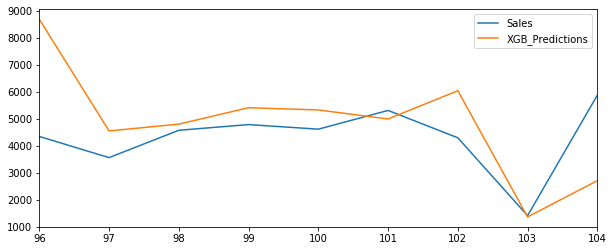

In [53]:
result_df[:9].plot(figsize=(10,4))

In [54]:
train.head(5).append(train.tail(5))

,Sales
Month,
1984-01-01,2815
1984-02-01,2672
1984-03-01,2755
1984-04-01,2721
1984-05-01,2946
1992-05-01,4618
1992-06-01,5312
1992-07-01,4298
1992-08-01,1413


# **AutoArima**

In [56]:
train[:-9].head(5)

,Sales
Month,
1984-01-01,2815
1984-02-01,2672
1984-03-01,2755
1984-04-01,2721
1984-05-01,2946


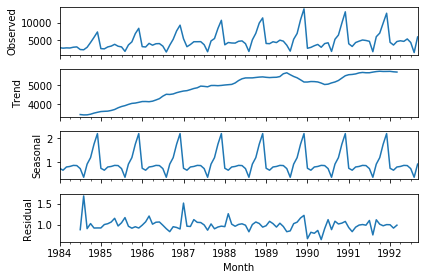

In [57]:
result = seasonal_decompose(train, model='multiplicative')
fig = result.plot()

In [0]:
arima_train = train[:-9]
arima_test = train[-9:]

(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [59]:
# Arima Training
now = datetime.now()
print("Arima process started at : ",now)

arima_stepwise_model = auto_arima(train, start_p=0, start_q=0,
                           max_p=13, max_q=13, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,
                           n_jobs=4)#n_jobs for parallel process
end = datetime.now()
print("Arima process finished at : ", end)
print("Process took : ", end-now)

print(arima_stepwise_model)

Arima process started at :  2020-03-15 17:02:31.802243


/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:379: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=1520.049, BIC=1527.614, Fit time=0.480 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1526.661, BIC=1531.705, Fit time=0.021 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1509.055, BIC=1519.143, Fit time=0.570 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1490.560, BIC=1500.647, Fit time=0.915 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1492.021, BIC=1504.630, Fit time=1.286 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1491.820, BIC=1499.385, Fit time=0.168 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1492.046, BIC=1504.655, Fit time=4.044 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1490.662, BIC=1505.792, Fit time=4.429 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1485.184, BIC=1497.793, Fit time=1.811 seconds
Fit ARIMA: order=(1, 1, 0) s

In [0]:
# Fit arima model
arima_predicts = arima_stepwise_model.fit(arima_train)

In [0]:
# Predict results with auto-arima
future_forecast = arima_predicts.predict(n_periods=9)

In [62]:
future_forecast

array([3580.72257032, 3091.80076194, 4095.4525918 , 4454.95797763,
       4605.29974041, 4651.2457211 , 4440.99372435, 1587.02820175,
       5696.16813252])

In [0]:
arima_rmse = sqrt(mean_squared_error(train['Sales'][-9:], future_forecast))

In [0]:
arima_mape = mean_absolute_percentage_error(train['Sales'][-9:], future_forecast)

In [65]:
print("Test RMSE:", np.mean(arima_rmse))
print("Test MAPE:", np.mean(arima_mape))

Test RMSE: 431.36506422601934
Test MAPE: 8.867407129635856


In [66]:
result_df['Arima_Predictions'] = future_forecast
result_df.head(9)

,Month,Sales,XGB_Predictions,Arima_Predictions
96,1992-01,4348,8691.643859,3580.722570
97,1992-02,3564,4552.308067,3091.800762
98,1992-03,4577,4804.287003,4095.452592
99,1992-04,4788,5413.343609,4454.957978
100,1992-05,4618,5330.312580,4605.299740
101,1992-06,5312,4996.354384,4651.245721
102,1992-07,4298,6042.409513,4440.993724
103,1992-08,1413,1366.224556,1587.028202
104,1992-09,5877,2709.482973,5696.168133


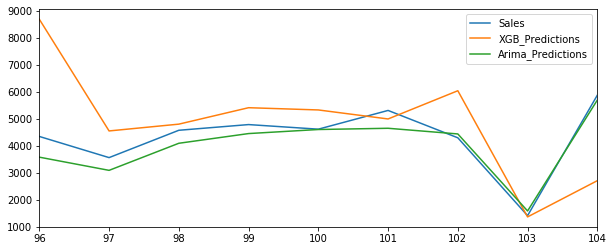

In [67]:
result_df[:9].plot(figsize=(10,4))

# **Long Short - Term Memory (LSTM)**

In [0]:
# define parameters
verbose, epochs, batch_size = 1, 50, 10
#n_timesteps, n_features, n_outputs = train_X_lstm.shape[1], train_X_lstm.shape[2], test_X_lstm.shape[1]
n_timesteps, n_features, n_outputs = train_X_lstm.shape[1], train_X_lstm.shape[2], train_Y_lstm.shape[1]

In [371]:
n_timesteps, n_features, n_outputs

(1, 12, 1)

In [0]:
# define model
lstm_model = Sequential()
lstm_model.add(Conv1D(filters=32, kernel_size=5,
                  strides=1, padding="causal",
                  activation="relu",
                  input_shape=(n_timesteps, n_features)))

In [0]:
lstm_model.add(LSTM(200, activation='relu', return_sequences=True))
# lstm_model.add(RepeatVector(n_outputs))
lstm_model.add(LSTM(200, activation='relu', return_sequences=True))
lstm_model.add(TimeDistributed(Dense(1, activation='relu')))  # 100
#lstm_model.add(TimeDistributed(Dense(1)))
#lstm_model.compile(loss='mse', optimizer=Adam(lr=0.001))
lstm_model.compile(loss='mse', optimizer=Adam(lr=0.001),
              metrics=['acc'])

In [374]:
train_X_lstm.shape, train_Y_lstm.shape

((83, 1, 12), (83, 1, 1))

In [375]:
now = datetime.now()

history = lstm_model.fit(train_X_lstm, train_Y_lstm, epochs=epochs, batch_size=batch_size, validation_data=(test_X_lstm, test_Y_lstm), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=verbose, shuffle=False)

lstm_model.summary()

end = datetime.now()
print("LSTM process finished at : ", end)
print("LSTM process took : ", end-now)

Train on 83 samples, validate on 9 samples
Epoch 1/50
83/83 [==============================] - 14s 164ms/step - loss: 0.5279 - acc: 0.0120 - val_loss: 0.4107 - val_acc: 0.0000e+00
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 0.3973 - acc: 0.0120 - val_loss: 0.2295 - val_acc: 0.0000e+00
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 0.1458 - acc: 0.0241 - val_loss: 0.0525 - val_acc: 0.0000e+00
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 0.0659 - acc: 0.0120 - val_loss: 0.0632 - val_acc: 0.0000e+00
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 0.0341 - acc: 0.0120 - val_loss: 0.0457 - val_acc: 0.0000e+00
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 0.0335 - acc: 0.0120 - val_loss: 0.0466 - val_acc: 0.0000e+00
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 0.0311 - acc: 0.0120 - val_loss: 0.0507 - val_acc: 0.0000e+00
Epoch 8/50
83/83

In [376]:
# Predict results with LSTM Model
lstm_predicts = lstm_model.predict(test_X_lstm, verbose=verbose)

9/9 [==============================] - 4s 492ms/step


In [377]:
lstm_predicts

array([[[0.18187752]],

       [[0.6419773 ]],

       [[0.777001  ]],

       [[0.7327224 ]],

       [[0.7243185 ]],

       [[0.67963505]],

       [[0.64164114]],

       [[0.45407313]],

       [[1.0033929 ]]], dtype=float32)

In [378]:
test_scaled

array([[0.13713148, 0.6747383 , 0.79651874, 0.74937373, 0.7457769 ,
        0.7155887 , 0.7088445 , 0.5333034 , 1.        , 0.7904811 ,
        0.90866464, 0.9053889 , 0.18980025],
       [0.6747383 , 0.79651874, 0.74937373, 0.7457769 , 0.7155887 ,
        0.7088445 , 0.5333034 , 1.        , 0.7904811 , 0.90866464,
        0.9053889 , 0.18980025, 0.6739675 ],
       [0.79651874, 0.74937373, 0.7457769 , 0.7155887 , 0.7088445 ,
        0.5333034 , 1.        , 0.7904811 , 0.90866464, 0.9053889 ,
        0.18980025, 0.6739675 , 0.7893892 ],
       [0.74937373, 0.7457769 , 0.7155887 , 0.7088445 , 0.5333034 ,
        1.        , 0.7904811 , 0.90866464, 0.9053889 , 0.18980025,
        0.6739675 , 0.7893892 , 0.73787653],
       [0.7457769 , 0.7155887 , 0.7088445 , 0.5333034 , 1.        ,
        0.7904811 , 0.90866464, 0.9053889 , 0.18980025, 0.6739675 ,
        0.7893892 , 0.73787653, 0.71340483],
       [0.7155887 , 0.7088445 , 0.5333034 , 1.        , 0.7904811 ,
        0.90866464, 0.90538

In [0]:
# Invert scaled predictons to time series
predictions = list()
start = 9 # test period
l = len(test_scaled) - start

lstm_rmse = []
lstm_mape = []

for i in range(len(test_scaled)):
    X1, y = test_scaled[l, 0:-1], test_scaled[l, -1]
    X1 = X1[-12:] # ts_window

    X1 = X1.reshape((1,-1))

    yhat = invert_scale(scaler, X1[0], lstm_predicts[i][0])
        
    l=l+1

    yhat = inverse_difference(train['Sales'], yhat, len(test_scaled) + 1 - i)

    predictions.append(yhat)

    lstm_rmse.append(sqrt(mean_squared_error([train['Sales'][-9:][i]], [yhat])))
    lstm_mape.append(mean_absolute_percentage_error([train['Sales'][-9:][i]], [yhat]))

In [380]:
predictions

[4224.651165872812,
 3065.944742202758,
 4384.128931641578,
 4707.755070805549,
 4787.9147939682,
 3922.238060951232,
 4024.7109084129324,
 90.46457785367875,
 5757.824601888655]

In [381]:
print("LSTM RMSE:", np.mean(lstm_rmse))
print("LSTM MAPE:", np.mean(lstm_mape))

LSTM RMSE: 463.2440815932228
LSTM MAPE: 17.16972564789466


In [382]:
result_df['LSTM_Predictions'] = predictions
result_df.head(9)

,Month,Sales,XGB_Predictions,Arima_Predictions,LSTM_Predictions
96,1992-01,4348,8691.643859,3580.722570,4224.651166
97,1992-02,3564,4552.308067,3091.800762,3065.944742
98,1992-03,4577,4804.287003,4095.452592,4384.128932
99,1992-04,4788,5413.343609,4454.957978,4707.755071
100,1992-05,4618,5330.312580,4605.299740,4787.914794
101,1992-06,5312,4996.354384,4651.245721,3922.238061
102,1992-07,4298,6042.409513,4440.993724,4024.710908
103,1992-08,1413,1366.224556,1587.028202,90.464578
104,1992-09,5877,2709.482973,5696.168133,5757.824602


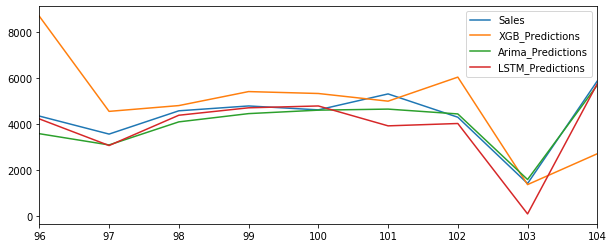

In [383]:
result_df[:9].plot(figsize=(10,4))

In [0]:
#Export dataframe as a csv
result_df.to_csv("results.csv", index=0)